In [3]:
import numpy as np
import scanpy.api as sc
from matplotlib import pyplot as plt

sc.settings.verbosity = 3                # verbosity = 3: errors, warnings, info, hints
sc.settings.set_figure_params(dpi=70)    # dots (pixels) per inch determine size of inline figures
sc.logging.print_version_and_date()

Running Scanpy version 0.2.8 on 2017-10-23 14:12.


In [7]:
filename_data = 'prog_matrix/matrix.mtx'
filename_genes = 'prog_matrix/genes.tsv'
filename_barcodes = 'prog_matrix/barcodes.tsv'
adata = sc.read(filename_data, cache=True).transpose()
adata.var_names = np.genfromtxt(filename_genes, dtype=str)[:, 1]
adata.smp_names = np.genfromtxt(filename_barcodes, dtype=str)


reading file prog_matrix/matrix.mtx
... did not find row_names or col_names
... writing an h5 cache file to speedup reading next time
writing ./write/data/prog_matrix/matrix.h5


In [8]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [10]:
mito_genes = np.array([name for name in adata.var_names if name.startswith('mt-')])
# for each cell compute fraction of counts in mito genes vs. all genes
adata.smp['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as sample annotation to adata
adata.smp['n_counts'] = np.sum(adata.X, axis=1).A1

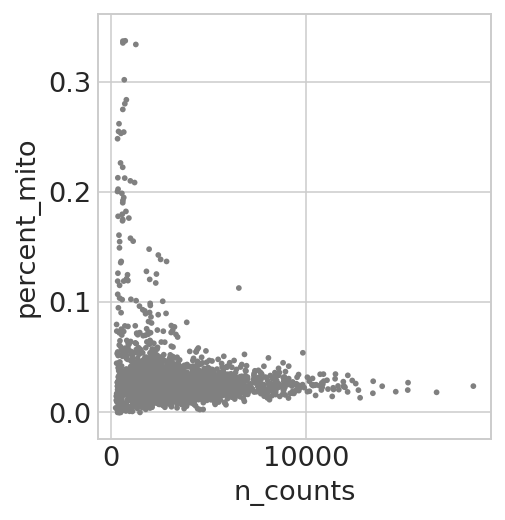

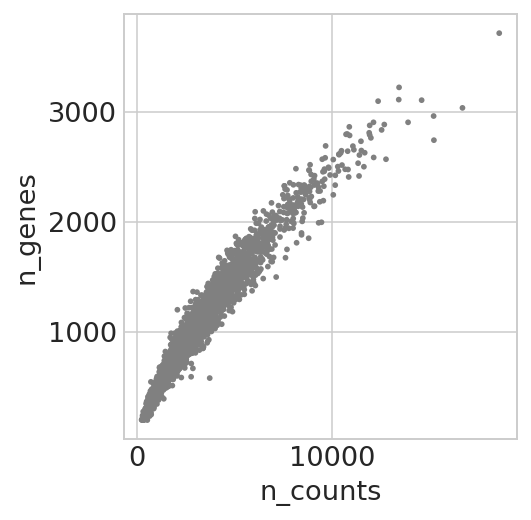

In [18]:
axs = sc.pl.scatter(adata, x='n_counts', y='percent_mito')
axs = sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [19]:
print(adata.n_smps)
adata[adata.smp['n_genes'] < 2500, :]
adata = adata[adata.smp['percent_mito'] < 0.05, :]
print(adata.n_smps)

3435
3257


In [21]:
sc.write('pbmc3k_filtered_raw_log', sc.pp.log1p(adata, copy=True))

writing ./write/pbmc3k_filtered_raw_log.h5


normalizing by total count per cell
    finished (0:00:00.070) normalized adata.X and added
    "n_counts", counts per cell before normalization (adata.smp)
filter highly varying genes by dispersion and mean (0:00:00.222)
--> set `n_top_genes` to simply select top-scoring genes instead


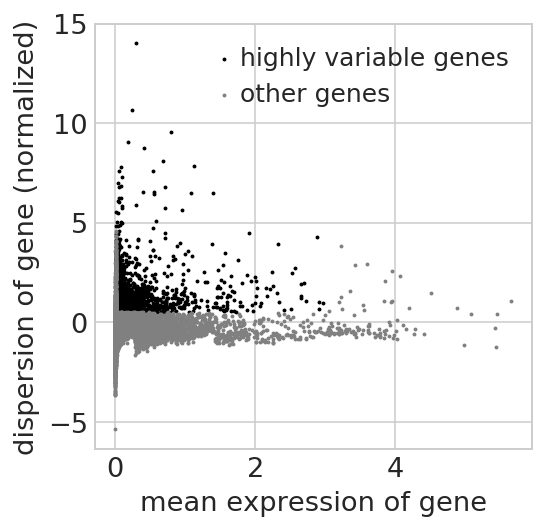

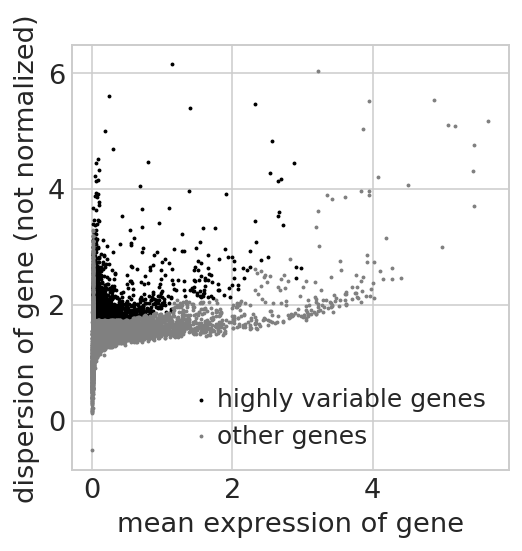

In [22]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result)

In [23]:
adata = adata[:, filter_result.gene_subset]
sc.pp.log1p(adata)

In [25]:
adata_corrected = sc.pp.regress_out(adata, ['n_counts', 'percent_mito'], copy=True)

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

In [26]:
sc.pp.scale(adata_corrected, max_value=10)

In [27]:
sc.write('pbmc3k_corrected', adata_corrected)

writing ./write/pbmc3k_corrected.h5


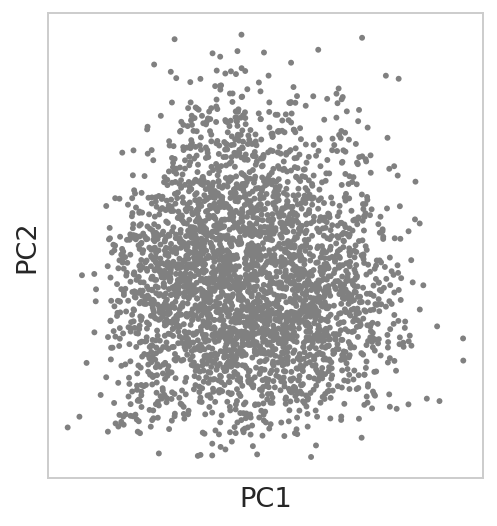

In [28]:
sc.tl.pca(adata_corrected)
ax = sc.pl.pca_scatter(adata_corrected, right_margin=0.2)

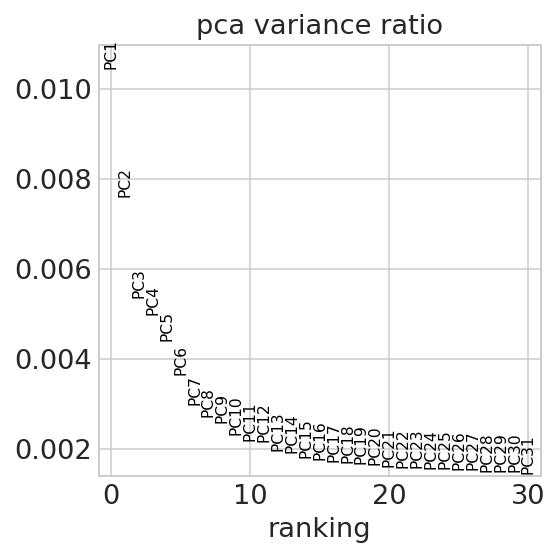

In [29]:
sc.pl.pca_variance_ratio(adata_corrected, log=0)

In [30]:
adata_corrected = sc.read('pbmc3k_corrected')

reading file ./write/pbmc3k_corrected.h5


In [31]:
sc.tl.tsne(adata_corrected, n_pcs=10)

computing tSNE
    preprocess using PCA with 10 PCs
--> avoid this by setting n_pcs = 0
    using 10 principal components
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished (0:01:02.072) and added
    "X_tsne", tSNE coordinates (adata.smp)


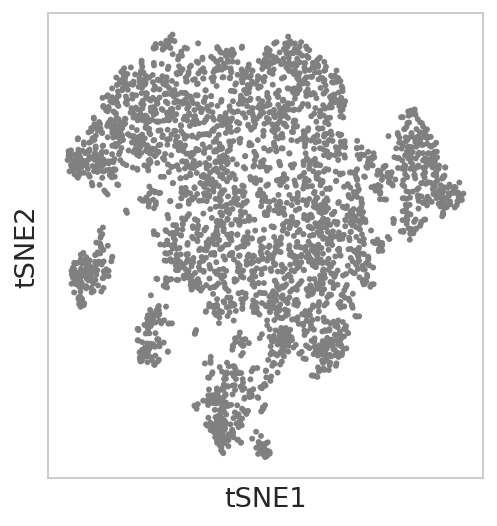

In [32]:
ax = sc.pl.tsne(adata_corrected)

In [113]:
sc.tl.louvain(adata_corrected, flavor="igraph", recompute_graph=True, n_pcs=10)

running Louvain clustering
    using "X_pca" for building graph
    computing data graph with n_neighbors = 30 
    computing spectral decomposition ("diffmap") with 15 components
    eigenvalues of transition matrix
    [ 1.            0.9577724934  0.9431377053  0.9368951917  0.9311164618
      0.9280424714  0.9101391435  0.895611763   0.8774354458  0.8548145294
      0.8430125117  0.8245911002  0.8078375459  0.7925785184  0.7888706326]
    finished (0:00:01.777) and found 10 clusters, added
    "louvain_groups", the cluster labels (adata.smp)
    "louvain_groups_order", the unique cluster labels (adata.add)


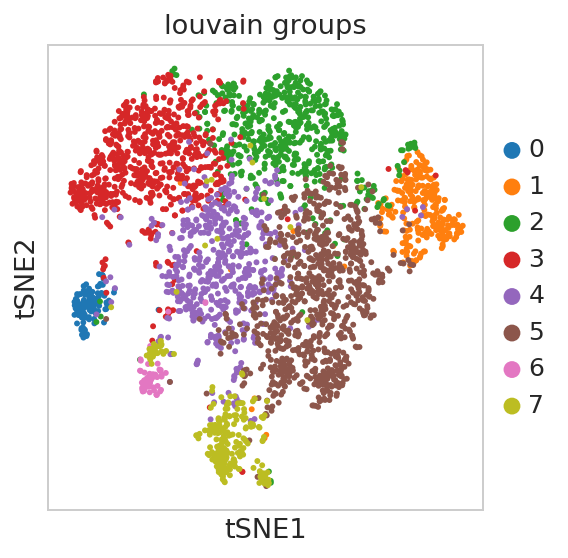

In [120]:
ax = sc.pl.tsne(adata_corrected, color='louvain_groups')

In [153]:
ax = sc.pl.tsne(adata_corrected, color='Adgre1')

ValueError: "Adgre1" is invalid! specify valid sample annotation, one of ['n_genes', 'percent_mito', 'n_counts', 'X_tsne', 'X_pca', 'X_diffmap', 'X_diffmap0', 'louvain_groups'] or a gene name ['Atp6v1h' 'Mcmdc2' 'Cspp1' ..., 'Cacul1' 'AC133103.1' 'Csprs']

In [35]:
sc.write('pbmc3k_corrected', adata_corrected)

writing ./write/pbmc3k_corrected.h5


reading file ./write/pbmc3k_corrected.h5
reading file ./write/pbmc3k_filtered_raw_log.h5
find differentially expressed genes
... consider "louvain_groups": ['0' '1' '2' '3' '4' '5' '6' '7'] with sample numbers [103 260 558 682 544 826  52 232]
    finished (0:00:01.108) and added
    "rank_genes_groups_gene_names", np.recarray to be indexed by the `groups` (adata.add)
    "rank_genes_groups_gene_zscores", the scores (adata.add)
    "rank_genes_...", distributions of top-ranked genes (adata.smp)


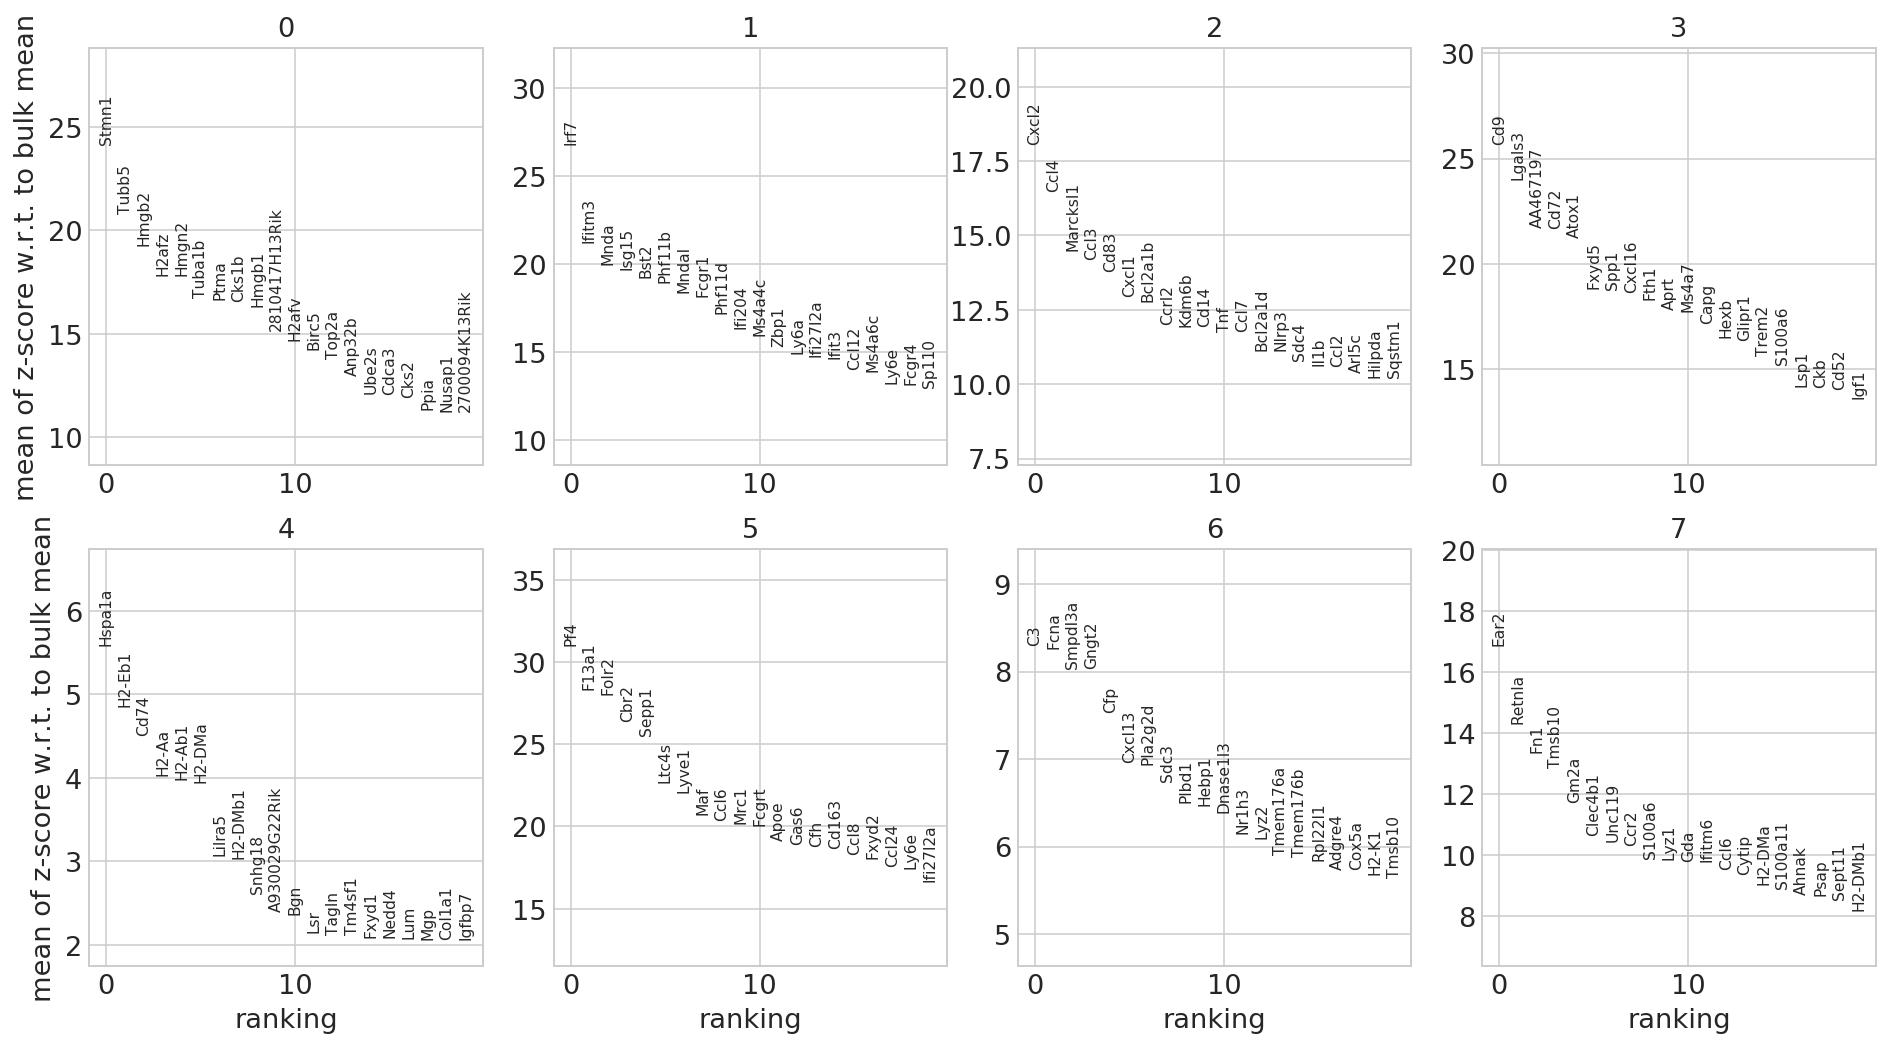

In [121]:
adata_corrected = sc.read('pbmc3k_corrected')
adata_raw = sc.read('pbmc3k_filtered_raw_log')
adata_raw.smp['louvain_groups'] = adata_corrected.smp['louvain_groups']
sc.tl.rank_genes_groups(adata_raw, 'louvain_groups')
sc.pl.rank_genes_groups(adata_raw, n_genes=20)

In [81]:
import pandas as pd
out_matrix = pd.DataFrame(adata.X.toarray())
out_matrix.columns = adata.var_names
out_matrix = out_matrix.T
out_matrix.to_csv("write/progmatrix.csv")

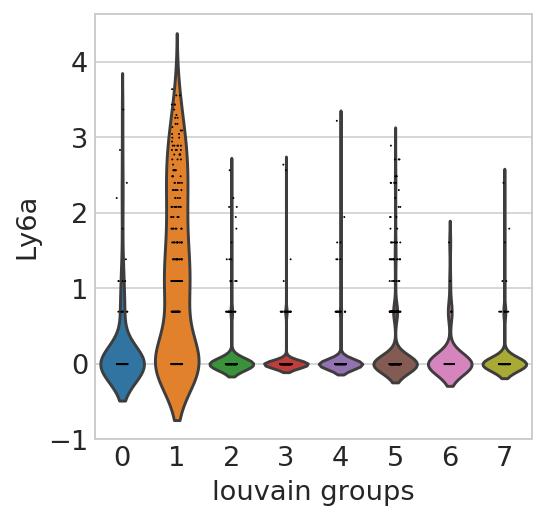

In [116]:
sc.pl.violin(adata_raw, 'Ly6a', group_by='louvain_groups')


perform Diffusion Pseudotime analysis
    using "X_pca" for building graph
    using stored data graph with n_neighbors = 30 and spectrum
    [ 1.            0.9217116237  0.9115762115  0.8863295913  0.8737409711
      0.8683188558  0.865996778   0.8525972366  0.8108855486  0.7709026933]
    detect 1 branching
    do not consider groups with less than 32 points for splitting
    branching 1: split group 0
finished (0:00:01.112) and added
    "dpt_pseudotime", the pseudotime (adata.smp),
    "dpt_groups", the branching subgroups of dpt (adata.smp)
    "dpt_order", order according to groups and increasing pseudtime (adata.smp)
    number of defined colors does not match number of categories, using palette


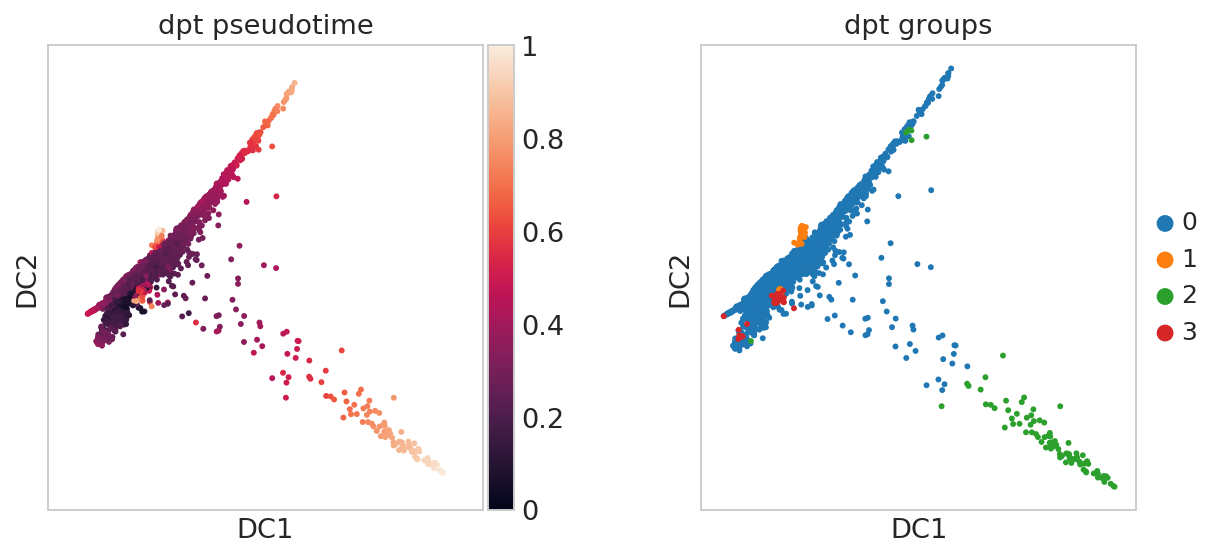

In [93]:
adata_corrected.add['iroot'] = 2761
dpt = sc.tl.dpt(adata_corrected, n_branchings=1)
sc.pl.dpt_scatter(adata_corrected, color=['dpt_pseudotime', 'dpt_groups'])

In [107]:
dpt_groups = pd.DataFrame([adata_corrected.smp_names, adata_corrected.smp["dpt_groups"]]).T
dpt_groups.columns = ["barcode", "id"]
dpt_groups.to_csv("write/dpt_groups.csv")